In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
categorical = pd.read_csv('categorical.csv')
numerical = pd.read_csv('numerical.csv')
target = pd.read_csv('target.csv')
df = pd.concat([numerical, categorical, target],axis=1)

In [3]:
df.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
0,0,60.000000,5,9,0,0,39,34,18,10,...,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,...,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,...,91,11,92,7,95,12,90,1,0,0.0
3,0,70.000000,1,4,2,0,23,14,31,3,...,87,11,94,11,95,12,87,2,0,0.0
4,0,78.000000,3,2,60,1,28,9,53,26,...,93,10,96,1,96,1,79,3,0,0.0


In [4]:
# categorical.dtypes

In [5]:
X = df.drop(columns=['TARGET_B','TARGET_D'])
y = df['TARGET_B']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Numerical

In [7]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

X_train_num = X_train_num.reset_index(drop=True)
X_test_num = X_test_num.reset_index(drop=True)

### Categorical

In [8]:
X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

In [9]:
target

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
95407,0,0.0
95408,0,0.0
95409,0,0.0
95410,1,18.0


In [10]:
target.isna().sum().sum()

0

In [11]:
target['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

### Encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
X_train_encode = encoder.transform(X_train_cat).toarray()
X_train_encode = pd.DataFrame(X_train_encode, columns=encoder.get_feature_names_out())

X_test_encode = encoder.transform(X_test_cat).toarray()
X_test_encode = pd.DataFrame(X_test_encode, columns=encoder.get_feature_names_out())

In [13]:
X_train_treated = pd.concat([X_train_num, X_train_encode],axis=1)
X_test_treated  = pd.concat([X_test_num,  X_test_encode],axis=1)

In [14]:
print(X_train_treated.isna().sum().sum())
print(X_test_treated.isna().sum().sum())

0
0


In [15]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled_oversample, y_resampled_oversample = ros.fit_resample(X_train_treated, y_train)

In [16]:
X_resampled = pd.DataFrame(X_resampled_oversample, columns=X_resampled_oversample.columns)

In [17]:
X_resampled.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0,84.000000,4,9,4,0,41,31,38,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,83.000000,5,9,0,0,48,23,48,3,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1,72.000000,2,1,2,0,28,21,52,7,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,61.611649,5,9,0,0,29,16,51,14,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,70.000000,5,9,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
X_train = X_resampled
X_test = X_test_treated
y_train = y_resampled_oversample

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6236231884057971
0.6106482209296232


In [20]:
%%time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


kbest = SelectKBest(chi2, k=10)
selector = kbest.fit(X_train, y_train)

X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

CPU times: user 641 ms, sys: 650 ms, total: 1.29 s
Wall time: 283 ms


In [21]:
df2 = pd.DataFrame(data = selector.scores_, columns = ['score'])
df2['Column'] = X_train.columns
print(df2.sort_values(by = ['score'], ascending = False).head(10))

            score    Column
311  5.821709e+06  CONTROLN
140  1.793196e+06       IC5
84   4.100439e+05       HV2
83   4.011307e+05       HV1
0    2.973278e+05     TCODE
133  2.512937e+05       MSA
13   7.616662e+04    POP901
137  3.034525e+04       IC2
136  2.786694e+04       IC1
139  2.767792e+04       IC4


In [22]:
columns = df2.sort_values(by = ['score'], ascending = False).head(10)['Column']
columns

311    CONTROLN
140         IC5
84          HV2
83          HV1
0         TCODE
133         MSA
13       POP901
137         IC2
136         IC1
139         IC4
Name: Column, dtype: object

In [23]:
selected = pd.DataFrame(X_train_new)
selected.head()
selected.columns = columns
selected.head()

Column,CONTROLN,IC5,HV2,HV1,TCODE,MSA,POP901,IC2,IC1,IC4
0,0.0,1415.0,682.0,714.0,3360.0,514.0,535.0,602.0,21655.0,121013.0
1,1.0,1356.0,557.0,609.0,0.0,218.0,279.0,372.0,13779.0,120686.0
2,1.0,798.0,311.0,340.0,0.0,173.0,233.0,294.0,9336.0,12945.0
3,0.0,1493.0,675.0,704.0,5080.0,347.0,408.0,448.0,16718.0,78349.0
4,2.0,1474.0,876.0,960.0,4720.0,488.0,594.0,638.0,22831.0,186838.0


In [24]:
clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train_new, y_train)
print(clf.score(X_train_new, y_train))
print(clf.score(X_test_new, y_test))

0.575527950310559
0.5773725305245506


In [25]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_new)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    18119
1      964
Name: TARGET_B, dtype: int64

array([[10569,  7550],
       [  515,   449]])

In [26]:
cost_FP = 7710*.68
cost_FN = 497*15

print(f'cost of sending mail to non donors is {cost_FP}')
print(f'cost of missing donors is {cost_FN}')

cost of sending mail to non donors is 5242.8
cost of missing donors is 7455


In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


max_depth_choices= [3,4,5,6,7,8,9,10,None]
min_samples_split_choices = [2,3,4,5,6,7,8,9,10]
min_samples_leaf_choices = [2,3,4,5,6,7,8,9,10]
max_samples_choices = [1, 0.9, 0.8, 0.7, 0.6]


random_grid = {'max_depth': max_depth_choices,
               'min_samples_split': min_samples_split_choices,
               'min_samples_leaf': min_samples_leaf_choices,
               'max_samples': max_samples_choices}

In [28]:
max_depth = range(1,20)
test = []
train = []

for depth in max_depth:
    model = RandomForestClassifier(max_depth=depth, random_state=0)
    model.fit(X_train_new, y_train)
    test.append(model.score(X_test_new,y_test))
    train.append(model.score(X_train_new,y_train))

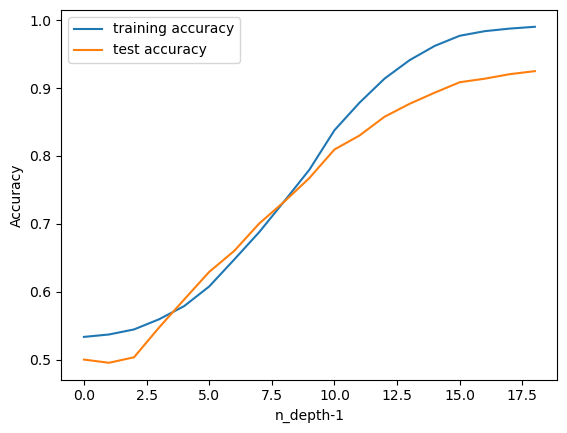

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()

In [30]:
cols = df2.sort_values(by = ['score'], ascending = False).head(10)['Column']
cols

311    CONTROLN
140         IC5
84          HV2
83          HV1
0         TCODE
133         MSA
13       POP901
137         IC2
136         IC1
139         IC4
Name: Column, dtype: object

In [31]:
X_train_B = pd.DataFrame(X_train_new)
X_train_B.head()
X_train_B.columns = cols
X_train_B

Column,CONTROLN,IC5,HV2,HV1,TCODE,MSA,POP901,IC2,IC1,IC4
0,0.0,1415.0,682.0,714.0,3360.0,514.0,535.0,602.0,21655.0,121013.0
1,1.0,1356.0,557.0,609.0,0.0,218.0,279.0,372.0,13779.0,120686.0
2,1.0,798.0,311.0,340.0,0.0,173.0,233.0,294.0,9336.0,12945.0
3,0.0,1493.0,675.0,704.0,5080.0,347.0,408.0,448.0,16718.0,78349.0
4,2.0,1474.0,876.0,960.0,4720.0,488.0,594.0,638.0,22831.0,186838.0
...,...,...,...,...,...,...,...,...,...,...
144895,2.0,872.0,957.0,1129.0,8200.0,418.0,417.0,438.0,14668.0,181655.0
144896,1002.0,13332.0,2123.0,2291.0,6780.0,458.0,480.0,539.0,16611.0,7836.0
144897,0.0,3673.0,886.0,1052.0,9270.0,318.0,339.0,388.0,12332.0,171521.0
144898,0.0,8146.0,5000.0,5748.0,4480.0,405.0,618.0,711.0,33566.0,144038.0


In [32]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=6,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8
                            )
cross_val_scores = cross_val_score(clf, X_train_B, y_train, cv=10)
print(np.mean(cross_val_scores))

0.597287784679089


In [33]:
cross_val_score(clf, X_train_B, y_train, cv=5, scoring='recall')

array([0.54099379, 0.57936508, 0.54458247, 0.5747412 , 0.54161491])

In [34]:
np.mean([0.58337935, 0.59707364, 0.61236886, 0.58738266, 0.59835726])

0.595712354

## Lab - Case Regression

In [75]:
donors = pd.concat([numerical, categorical, target],axis=1)
donors.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
0,0,60.000000,5,9,0,0,39,34,18,10,...,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,...,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,...,91,11,92,7,95,12,90,1,0,0.0
3,0,70.000000,1,4,2,0,23,14,31,3,...,87,11,94,11,95,12,87,2,0,0.0
4,0,78.000000,3,2,60,1,28,9,53,26,...,93,10,96,1,96,1,79,3,0,0.0


In [76]:
donated = donors[donors['TARGET_B']==1]
donated.shape

(4843, 339)

In [77]:
X = donated.drop(['TARGET_B','TARGET_D'],axis=1)
y_regr =donated ['TARGET_D']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y_regr, test_size=0.2, random_state=0)

X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat = X_test.select_dtypes(object) 

In [79]:
transformer_regr = MinMaxScaler().fit(X_train_num)
scaled_train = transformer_regr.transform(X_train_num)
X_train_scaled = pd.DataFrame(scaled_train, columns=X_train_num.columns)

scaled_test  = transformer_regr.transform(X_test_num)
X_test_scaled  = pd.DataFrame(scaled_test, columns=X_train_num.columns)

In [80]:
encoder_regr = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat_train = encoder_regr.transform(X_train_cat).toarray()
X_train_encoded = pd.DataFrame(encoded_cat_train, columns=encoder_regr.get_feature_names_out())

encoded_cat_test = encoder_regr.transform(X_test_cat).toarray()
X_test_encoded = pd.DataFrame(encoded_cat_test, columns=encoder_regr.get_feature_names_out())

In [81]:
X_train=pd.concat([X_train_scaled, X_train_encoded],axis=1)
X_test=pd.concat([X_test_scaled,X_test_encoded],axis=1)

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model_list=[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(max_depth=2),RandomForestRegressor(max_depth=3)]

In [83]:
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

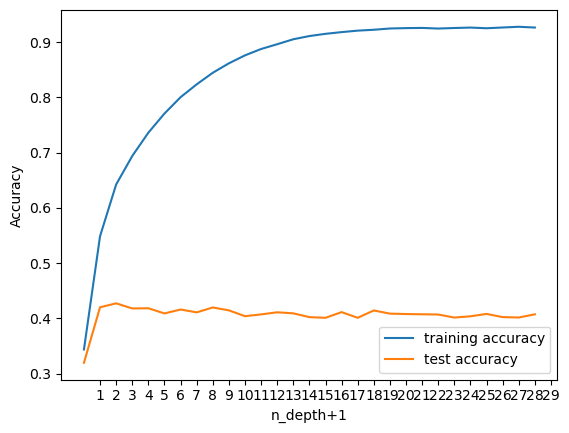

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.xticks(max_depth)
plt.ylabel("Accuracy")
plt.xlabel("n_depth+1")
plt.legend()

#highest score at max_depth=3

In [85]:
def validate_model(models, X_tr, y_tr):
    for model in models:
        results= cross_validate(model,X_tr,y_tr,cv=5)
        print(f"Results for {model.__class__.__name__}:")
        print('Test scores: ', results['test_score'])
        print('Mean:', results['test_score'].mean(), '\n')

In [87]:
model= LinearRegression(copy_X= True, fit_intercept=False, positive= True)
model.fit(X_train,y_train)

LinearRegression(fit_intercept=False, positive=True)